In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler
%matplotlib inline

In [73]:
df = pd.read_csv('dataset.csv')

In [74]:
kategori = ['OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType', 'Weekend', 'Revenue']
numerikal = ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration',  
             'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues','SpecialDay']
date = ['Month']

## Missing Value

In [75]:
df.isna().sum()

Administrative             111
Administrative_Duration    633
Informational                0
Informational_Duration       0
ProductRelated               0
ProductRelated_Duration    639
BounceRates                 74
ExitRates                    0
PageValues                   0
SpecialDay                   0
Month                        0
OperatingSystems           524
Browser                      0
Region                       0
TrafficType                  0
VisitorType                  0
Weekend                      0
Revenue                      0
dtype: int64

Dikarenakan jumlah data numerik yang null berpotensi cukup banyak, bisa kita fill menggunakan median. Dipilih median karena sebaran data yang skew ke kanan, sehingga nilai mean lebih tinggi dari median.

In [76]:
df['Administrative'] = df['Administrative'].fillna(value=df['Administrative'].median())
df['Administrative_Duration'] = df['Administrative_Duration'].fillna(value=df['Administrative_Duration'].median())
df['ProductRelated_Duration'] = df['ProductRelated_Duration'].fillna(value=df['ProductRelated_Duration'].median())
df['BounceRates'] = df['BounceRates'].fillna(value=df['BounceRates'].median())

Data kategorikal yang null tidak terlalu banyak sehingga bisa kita drop

In [77]:
df = df.dropna(subset=['OperatingSystems'])

In [78]:
df.isna().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

## Duplicated Data

In [79]:
df.duplicated().sum()

694

Hapus duplikat tapi simpan nilai yang pertama muncul.

In [80]:
df = df.drop_duplicates(keep='first')

In [81]:
df.duplicated().sum()

0

## Handle Categorical

### Grouping

Penamaan data kategorikal berdasarkan EDA di stage 1

In [82]:
df.Region = df.Region.astype('string').replace(['1', '2', '3', '4', '5', '6', '7', '8', '9'],
                      ['Jakarta', 'Bandung', 'Surabaya', 'Medan', 'Batam', 'Makassar', 'Tangerang', 'Yogyakarta', 'Semarang'])

df.Browser = df.Browser.astype('string').replace(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13'],
                                ['Safari', 'Google Chrome', 'Internet Explorer', 'Mozilla Firefox', 'Microsoft Edge', 'Samsung Internet', 'Maxthon Browser', 'Brave', 'Vivaldi', 'UC Browser', 'DuckDuckGo', 'Opera', 'Netscape Navigator'])

df.OperatingSystems = df.OperatingSystems.astype('string').replace(['1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0'],
                                                  ['iOS', 'Windows', 'Android', 'MAC OS', 'Blackberry', 'Chrome Os', 'Unix', 'Linux'])

df.TrafficType = df.TrafficType.astype('string').replace(['1', '2', '3', '4', '5', '6', '8', '10', '13'],
                                        ['Organic Search', 'Paid Search', 'Direct Traffic', 'Social Media', 'Facebook Ads', 'Referral Traffic', 'Email Marketing ', 'Display Advertising', 'Affiliate Marketing'])

beberapa data memiliki count yang sangat kecil seperti :  
  
- VisitorType : Other  
- Operating system : 4 (Mac OS), 5 (Blackberry OS), 6 (Chrome OS), 7 (Unix), 8  
- browser : 7 (Maxthon), 9 (Vivaldi), 11 (DuckDuckGo), 12 (Opera), 13 (Netscape)  
- traffic type : 9,7,12,14,15,16,17,18,19  
data ini memiliki potensi untuk didrop atau digabung menjadi "other"  

In [83]:
df = df.drop(df.loc[df['VisitorType'] =='Other'].index) 

In [84]:
os_replace = ['MAC OS', 'Blackberry', 'Chrome Os', 'Unix', 'Linux']
browser_replace =  ['Maxthon Browser', 'Vivaldi', 'DuckDuckGo', 'Opera', 'Netscape Navigator']
traffic_replace = ['9','7','12','14','15','16','17','18','19']

In [85]:
df['OperatingSystems'] = df['OperatingSystems'].astype('string').replace(to_replace=os_replace,value='other')
df['Browser'] = df['Browser'].astype('string').replace(to_replace=browser_replace,value='other')
df['TrafficType'] = df['TrafficType'].astype('string').replace(to_replace=traffic_replace,value='other')

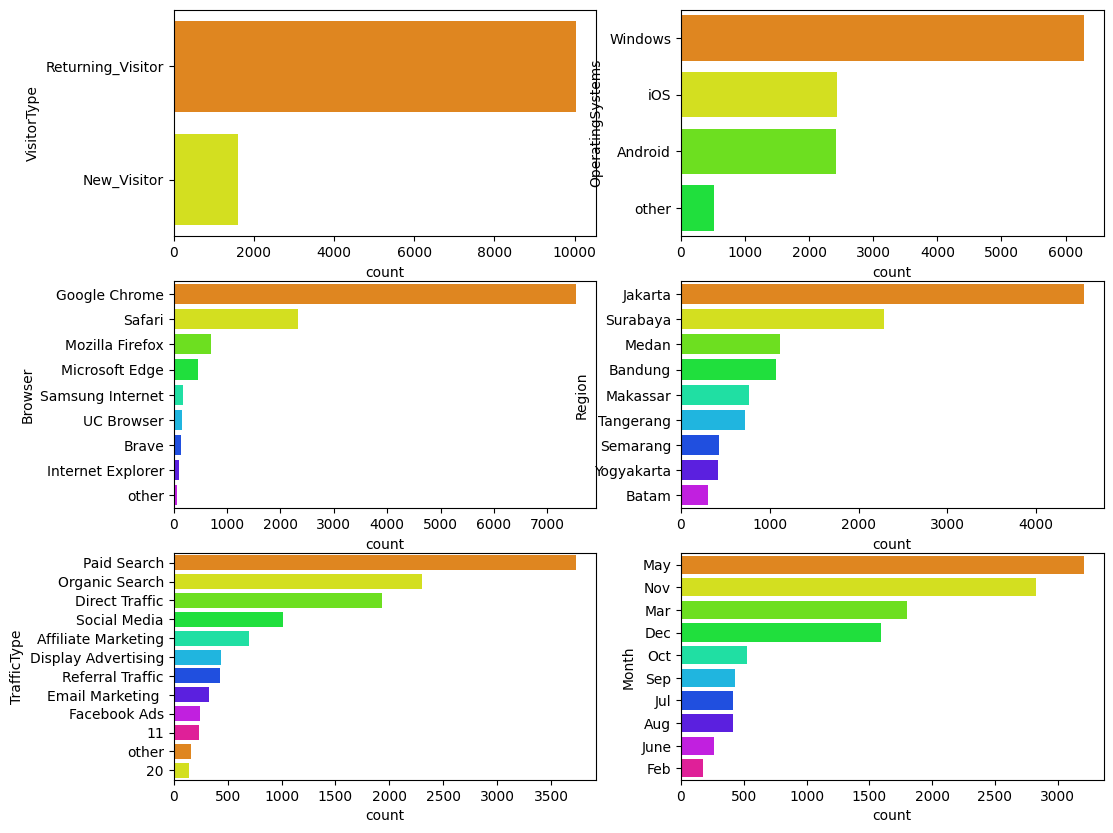

In [86]:
cat2 = ['VisitorType','OperatingSystems', 'Browser', 'Region', 'TrafficType','Month']
palette = sns.color_palette("hsv", 10)
plt.figure(figsize=(12, 10))
for i in range(0,len(cat2)):
    plt.subplot(3,2,i+1)
    sns.countplot(y=df[cat2[i]],order = df[cat2[i]].value_counts().index,palette=palette)

### Feature encoding

Semua fitur kategorikal tidak memiki sifat berurutan atau memiliki derajat, sehingga bisa dilakukan one hot encoding.

In [87]:
from sklearn.preprocessing import OneHotEncoder

columns_to_encode = ['OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType', 'Weekend','Month']
df = pd.get_dummies(df, columns=columns_to_encode)

## Handling Numerical

### Outlier

In [88]:
outlier = ['Administrative','Administrative_Duration','Informational','Informational_Duration',
           'ProductRelated','ProductRelated_Duration','BounceRates','ExitRates',
           'PageValues']

Dikarenakan sebaran data yang skew ke kanan, diterapkan log transformation untuk menormalkan sebaran data

In [89]:
for num in df[outlier]:
    min_value = df[df[num] > 0][num].min() / 2
    df[num] = np.log(df[num] + min_value)

In [90]:
print(f'Jumlah baris sebelum memfilter outlier: {len(df)}')

filtered_entries = np.array([True] * len(df))

for col in outlier:
    zscore = abs(stats.zscore(df[col])) 
    filtered_entries = (zscore < 3) & filtered_entries
    
df_zscore = df[filtered_entries] 

print(f'Jumlah baris setelah memfilter outlier: {len(df_zscore)}')

Jumlah baris sebelum memfilter outlier: 11649
Jumlah baris setelah memfilter outlier: 10719


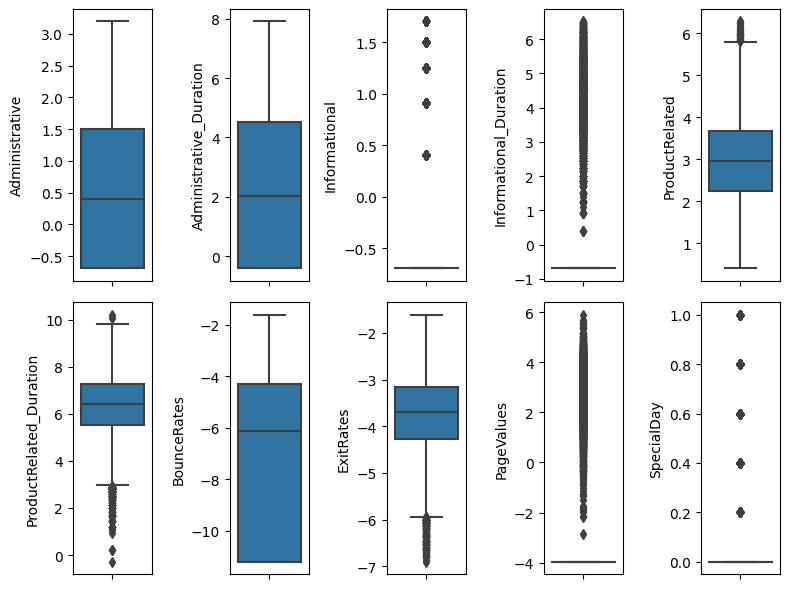

In [91]:
plt.figure(figsize=(8, 6))
for i in range(0,len(numerikal)):
    plt.subplot(2,5,i+1)
    sns.boxplot(y=df_zscore[numerikal[i]],orient='v')
    plt.tight_layout()

In [92]:
df = df_zscore

In [93]:
# df['Avg_Duration'] = df['ProductRelated_Duration']/df['ProductRelated']
# df['Inf_Duration'] = df["Informational_Duration"]/df['Informational']
# df['Admin_Duration']=df['Administrative_Duration']/df['Administrative']

In [94]:
df.drop(columns=['Administrative_Duration'], inplace=True)
df.drop(columns=['Informational_Duration'], inplace=True)
df.drop(columns=['ProductRelated_Duration'], inplace=True)
df.drop(columns=['SpecialDay'], inplace =True)
df.drop(columns=['PageValues'], inplace=True)

df.drop(columns=['BounceRates'], inplace=True)

In [95]:
df['not_revenue']  = np.where(df['Revenue'] == True,False,True)

In [96]:
df

,Administrative,Informational,ProductRelated,ExitRates,Revenue,OperatingSystems_Android,OperatingSystems_Windows,OperatingSystems_iOS,OperatingSystems_other,Browser_Brave,...,Month_Dec,Month_Feb,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,not_revenue
1,-0.693147,-0.693147,0.916291,-2.301708,False,False,True,False,False,False,...,False,True,False,False,False,False,False,False,False,True
3,-0.693147,-0.693147,0.916291,-1.965486,False,True,False,False,False,False,...,False,True,False,False,False,False,False,False,False,True
4,-0.693147,-0.693147,2.351375,-2.993978,False,True,False,False,False,False,...,False,True,False,False,False,False,False,False,False,True
5,-0.693147,-0.693147,2.970414,-3.703011,False,False,True,False,False,False,...,False,True,False,False,False,False,False,False,False,True
8,-0.693147,-0.693147,0.916291,-2.301708,False,False,True,False,False,False,...,False,True,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12325,1.252763,-0.693147,3.979682,-3.536385,False,False,False,False,True,False,...,True,False,False,False,False,False,False,False,False,True
12326,-0.693147,-0.693147,1.704748,-3.843377,False,True,False,False,False,False,...,False,False,False,False,False,False,True,False,False,True
12327,-0.693147,-0.693147,1.871802,-2.444673,False,True,False,False,False,False,...,False,False,False,False,False,False,True,False,False,True
12328,1.504077,-0.693147,2.740840,-3.856568,False,False,True,False,False,False,...,False,False,False,False,False,False,True,False,False,True


### Splitting Data

Sebelum scaling data, dilakukan splitting terlebih dahulu untuk menghindari data leakage

In [97]:
from sklearn.model_selection import train_test_split


X = df.drop(columns=['not_revenue','Revenue'])
y= df['not_revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (8575, 52)
X_test shape: (2144, 52)
y_train shape: (8575,)
y_test shape: (2144,)


### Scaling Data

Dilakukan scaling data menggunakan standardisasi. Dipilih standardisasi karena tidak terlalu sensitif ke outlier

In [98]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train) 
X_train_scaled = scaler.transform(X_train)  
X_test_scaled = scaler.transform(X_test) 

In [99]:
df['not_revenue'].value_counts(normalize=True)* 100

not_revenue
True     84.047019
False    15.952981
Name: proportion, dtype: float64

<span style="font-size:25px;">**Handling Class Imbalance**

Karena fitur dependant bersifat sangat imbalance, dilakukan handling menggunakan teknik SMOTE

In [100]:
from imblearn.over_sampling import SMOTE
from collections import Counter


smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train_scaled, y_train)

print('Original dataset shape:', Counter(y_train))
print('Resampled dataset shape:', Counter(y_res))


Original dataset shape: Counter({True: 7230, False: 1345})
Resampled dataset shape: Counter({True: 7230, False: 7230})


In [101]:
print('Original dataset shape:', X_train_scaled.shape)
print('Resampled dataset shape:', X_res.shape)

Original dataset shape: (8575, 52)
Resampled dataset shape: (14460, 52)


<span style="font-size:25px;">**Feature Engineering**

In [102]:
numerikal2 =  ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration',  
             'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues',
               'SpecialDay','Revenue']


In [103]:
# sns.heatmap(df[numerikal2].corr(), annot= True, fmt = ' .2f')

In [104]:
kategori_baru = ['OperatingSystems_Android', 'OperatingSystems_Windows',
       'OperatingSystems_iOS', 'OperatingSystems_other', 'Browser_Brave',
       'Browser_Google Chrome', 'Browser_Internet Explorer',
       'Browser_Microsoft Edge', 'Browser_Mozilla Firefox', 'Browser_Safari',
       'Browser_Samsung Internet', 'Browser_UC Browser', 'Browser_other',
       'Region_Bandung', 'Region_Batam', 'Region_Jakarta', 'Region_Makassar',
       'Region_Medan', 'Region_Semarang', 'Region_Surabaya',
       'Region_Tangerang', 'Region_Yogyakarta', 'TrafficType_11',
       'TrafficType_20', 'TrafficType_Affiliate Marketing',
       'TrafficType_Direct Traffic', 'TrafficType_Display Advertising',
       'TrafficType_Email Marketing ', 'TrafficType_Facebook Ads',
       'TrafficType_Organic Search', 'TrafficType_Paid Search',
       'TrafficType_Referral Traffic', 'TrafficType_Social Media',
       'TrafficType_other', 'VisitorType_New_Visitor',
       'VisitorType_Returning_Visitor', 'Weekend_False', 'Weekend_True',
       'Month_Aug', 'Month_Dec', 'Month_Feb', 'Month_Jul', 'Month_June',
       'Month_Mar', 'Month_May', 'Month_Nov', 'Month_Oct', 'Month_Sep']

In [105]:
# from scipy.stats import pointbiserialr

# correlation_results = {}
# for column in df[kategori_baru]:
#     if column != 'Revenue':  
#         corr, p_value = pointbiserialr(df[column], df['Revenue'])
#         correlation_results[column] = corr

# for column, correlation in correlation_results.items():
#     print(f"Correlation between 'Revenue' and '{column}': {correlation:.2f}")


In [106]:
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, f_classif

k_best = SelectKBest(score_func=mutual_info_classif, k=25) 
X_train_selected = k_best.fit_transform(X_res, y_res)
selected_mask = k_best.get_support()
selected_feature_names = X.columns[selected_mask]
print("Selected features:", selected_feature_names)

Selected features: Index(['Administrative', 'Informational', 'ProductRelated', 'ExitRates',
       'OperatingSystems_Android', 'OperatingSystems_Windows',
       'OperatingSystems_iOS', 'Browser_Google Chrome', 'Browser_Safari',
       'Region_Bandung', 'Region_Jakarta', 'Region_Medan', 'Region_Surabaya',
       'TrafficType_Direct Traffic', 'TrafficType_Organic Search',
       'TrafficType_Paid Search', 'TrafficType_Social Media',
       'VisitorType_New_Visitor', 'VisitorType_Returning_Visitor',
       'Weekend_False', 'Weekend_True', 'Month_Dec', 'Month_Mar', 'Month_May',
       'Month_Nov'],
      dtype='object')


**Feature Selection**

Mengdrop feature:  
-Administrative_Duration karena highly correlated dengan Administrative  
-Informational_Duration karena highly correlated dengan Informational  
-ProductRelated_Duration karena highly correlated dengan ProductRelated  
-SpecialDay karena korelasi dengan target sangat rendah  



**Feature Tambahan**

1. Session hour
2. Has promo
3. Top product related
4. Kategori

# Modeling

In [107]:
 result_df = pd.DataFrame(columns=[
       
    ])

In [108]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_validate

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

def eval_classification(model):
    y_pred_train = model.predict(X_res)
    y_pred_test = model.predict(X_test_scaled)
    y_pred_proba_train = model.predict_proba(X_res)
    y_pred_proba_test = model.predict_proba(X_test_scaled)

    acc_train = accuracy_score(y_res, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred_test)
    precision_train = precision_score(y_res, y_pred_train)
    precision_test = precision_score(y_test, y_pred_test)
    recall_train = recall_score(y_res, y_pred_train)
    recall_test = recall_score(y_test, y_pred_test)
    f1_train = f1_score(y_res, y_pred_train)
    f1_test = f1_score(y_test, y_pred_test)
    auc_train = roc_auc_score(y_res, y_pred_proba_train[:, 1])
    auc_test = roc_auc_score(y_test, y_pred_proba_test[:, 1])

    print("Accuracy (Train Set): %.2f" % acc_train)
    print("Accuracy (Test Set): %.2f" % acc_test)
    print("Precision (Train Set): %.2f" % precision_train)
    print("Precision (Test Set): %.2f" % precision_test)
    print("Recall (Train Set): %.2f" % recall_train)
    print("Recall (Test Set): %.2f" % recall_test)
    print("F1-Score (Train Set): %.2f" % f1_train)
    print("F1-Score (Test Set): %.2f" % f1_test)
    print("roc_auc (train-proba): %.2f" % auc_train)
    print("roc_auc (test-proba): %.2f" % auc_test)
    #
    score = cross_validate(model, X_res, y_res, cv=5, scoring='recall', return_train_score=True)
    print('recall (crossval test): '+ str(score['test_score'].mean()))

    data = pd.DataFrame({"Model" : [str(model)],
                         'Accuracy train' : [acc_train],
                         'Accuracy test' : [acc_test],
                         'Precision train' : [precision_train],
                         'Precision test' : [precision_test],
                         'Recall train' : [recall_train],
                         'Recall test' : [recall_test],
                         'F1 Score train' : [f1_train],
                         'F1 Score test' : [f1_test],
                         'AUC train' : [auc_train],
                         'AUC test' : [auc_test],
                         'accuracy_cv' : [score['test_score'].mean()]
                         })

    return data


def show_feature_importance(model):
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    ax = feat_importances.nlargest(25).plot(kind='barh', figsize=(10, 8))
    ax.invert_yaxis()

    plt.xlabel('score')
    plt.ylabel('feature')
    plt.title('feature importance score')

def show_feature_coef(model):
    coefficients = model.coef_

    avg_importance = np.mean(np.abs(coefficients), axis=0)
    feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': avg_importance})
    feature_importance = feature_importance.sort_values('Importance', ascending=True)
    feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))


### Logistic Regression

In [109]:
lr = LogisticRegression() 
lr.fit(X_res, y_res) 
result = eval_classification(lr)
result_df = pd.concat([result_df, result], ignore_index=True)

Accuracy (Train Set): 0.69
Accuracy (Test Set): 0.66
Precision (Train Set): 0.70
Precision (Test Set): 0.91
Recall (Train Set): 0.67
Recall (Test Set): 0.66
F1-Score (Train Set): 0.68
F1-Score (Test Set): 0.77
roc_auc (train-proba): 0.76
roc_auc (test-proba): 0.73
recall (crossval test): 0.665283540802213


### KNN

In [110]:
k = 3
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_res, y_res)
result = eval_classification(knn)
result_df = pd.concat([result_df, result], ignore_index=True)

Accuracy (Train Set): 0.92
Accuracy (Test Set): 0.68
Precision (Train Set): 0.99
Precision (Test Set): 0.86
Recall (Train Set): 0.84
Recall (Test Set): 0.74
F1-Score (Train Set): 0.91
F1-Score (Test Set): 0.79
roc_auc (train-proba): 0.99
roc_auc (test-proba): 0.61
recall (crossval test): 0.694744121715076


### Decision Tree

In [111]:
dt = DecisionTreeClassifier() 
dt.fit(X_res, y_res) 
result = eval_classification(dt)
result_df = pd.concat([result_df, result], ignore_index=True)

Accuracy (Train Set): 1.00
Accuracy (Test Set): 0.74
Precision (Train Set): 1.00
Precision (Test Set): 0.85
Recall (Train Set): 1.00
Recall (Test Set): 0.82
F1-Score (Train Set): 1.00
F1-Score (Test Set): 0.84
roc_auc (train-proba): 1.00
roc_auc (test-proba): 0.57
recall (crossval test): 0.833609958506224


### Random Forest

In [112]:
rf = RandomForestClassifier() # inisiasi object dengan nama rf
rf.fit(X_res, y_res) # fit model decision tree dari data train
result = eval_classification(rf)
result_df = pd.concat([result_df, result], ignore_index=True)

Accuracy (Train Set): 1.00
Accuracy (Test Set): 0.81
Precision (Train Set): 1.00
Precision (Test Set): 0.85
Recall (Train Set): 1.00
Recall (Test Set): 0.93
F1-Score (Train Set): 1.00
F1-Score (Test Set): 0.89
roc_auc (train-proba): 1.00
roc_auc (test-proba): 0.74
recall (crossval test): 0.9250345781466113


### Gradient Boosting

In [113]:
gb = GradientBoostingClassifier() # inisiasi object dengan nama rf
gb.fit(X_res, y_res) # fit model decision tree dari data train
result = eval_classification(gb)
result_df = pd.concat([result_df, result], ignore_index=True)

Accuracy (Train Set): 0.88
Accuracy (Test Set): 0.81
Precision (Train Set): 0.86
Precision (Test Set): 0.87
Recall (Train Set): 0.92
Recall (Test Set): 0.91
F1-Score (Train Set): 0.88
F1-Score (Test Set): 0.89
roc_auc (train-proba): 0.95
roc_auc (test-proba): 0.75
recall (crossval test): 0.9065006915629322


### Light gradient boosting

In [114]:
lgb = LGBMClassifier() # inisiasi object dengan nama rf
lgb.fit(X_res, y_res) # fit model decision tree dari data train
result = eval_classification(lgb)
result_df = pd.concat([result_df, result], ignore_index=True)

[LightGBM] [Info] Number of positive: 7230, number of negative: 7230
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007026 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6525
[LightGBM] [Info] Number of data points in the train set: 14460, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Accuracy (Train Set): 0.92
Accuracy (Test Set): 0.83
Precision (Train Set): 0.88
Precision (Test Set): 0.85
Recall (Train Set): 0.98
Recall (Test Set): 0.96
F1-Score (Train Set): 0.93
F1-Score (Test Set): 0.90
roc_auc (train-proba): 0.98
roc_auc (test-proba): 0.76
[LightGBM] [Info] Number of positive: 5784, number of negative: 5784
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004570 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Li

### XGBoost

In [115]:
XGboost = xgb.XGBClassifier()
XGboost.fit(X_res, y_res)
result = eval_classification(XGboost)
result_df = pd.concat([result_df, result], ignore_index=True)

Accuracy (Train Set): 0.95
Accuracy (Test Set): 0.81
Precision (Train Set): 0.91
Precision (Test Set): 0.85
Recall (Train Set): 0.99
Recall (Test Set): 0.95
F1-Score (Train Set): 0.95
F1-Score (Test Set): 0.89
roc_auc (train-proba): 0.99
roc_auc (test-proba): 0.74
recall (crossval test): 0.940802213001383


In [116]:
result_df

,Model,Accuracy train,Accuracy test,Precision train,Precision test,Recall train,Recall test,F1 Score train,F1 Score test,AUC train,AUC test,accuracy_cv
0,LogisticRegression(),0.688797,0.664646,0.697483,0.910853,0.666805,0.660483,0.681799,0.765722,0.757851,0.731354,0.665284
1,KNeighborsClassifier(n_neighbors=3),0.917981,0.683769,0.992343,0.862409,0.842462,0.736369,0.911281,0.794421,0.992891,0.609443,0.694744
2,DecisionTreeClassifier(),1.000000,0.737407,1.000000,0.853900,1.000000,0.824621,1.000000,0.839005,1.000000,0.568475,0.833610
3,RandomForestClassifier(),1.000000,0.811567,1.000000,0.854564,1.000000,0.931422,1.000000,0.891339,1.000000,0.735654,0.925035
4,GradientBoostingClassifier(),0.880498,0.809235,0.855518,0.867489,0.915629,0.908938,0.884554,0.887730,0.948971,0.745456,0.906501
5,LGBMClassifier(),0.921715,0.828358,0.878758,0.851870,0.978423,0.960090,0.925916,0.902748,0.978645,0.758186,0.947165
6,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.945643,0.813433,0.910655,0.847006,0.988243,0.946037,0.947864,0.893787,0.990949,0.737228,0.940802


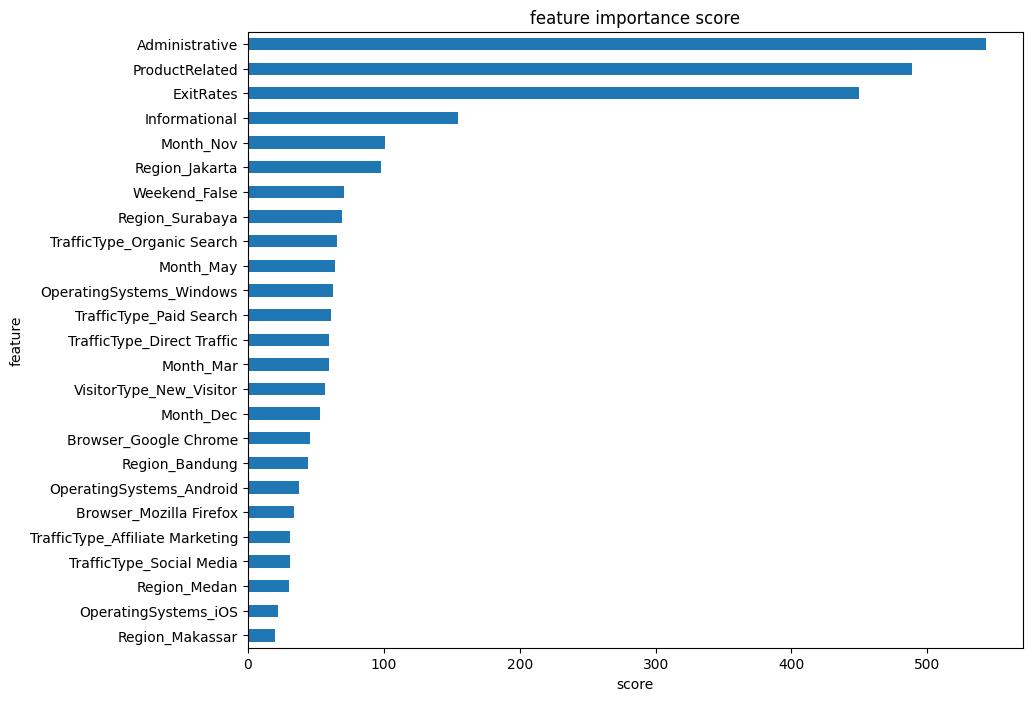

In [47]:
show_feature_importance(lgb)

In [48]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import uniform

# List of hyperparameter
num_leaves = [31,61,91]
max_depth = [10,20,-1]
learning_rate = [0.05, 0.1, 0.2]
n_estimator = [100,200,300]
# subsample = 
# colsample_bytree = 

hyperparameters = dict(
                    num_leaves = num_leaves,
                    max_depth = max_depth ,
                    learning_rate = learning_rate ,
                    n_estimator = n_estimator ,
                      )

# Inisialisasi Model
lgb_hy = LGBMClassifier(random_state=42)
model_hy = GridSearchCV(lgb, hyperparameters, cv=5, scoring='recall')
model_hy.fit(X_res, y_res)

# Predict & Evaluation
y_pred = model_hy.predict(X_test_scaled)#Check performa dari model
eval_classification(model_hy)

[LightGBM] [Warning] Unknown parameter: n_estimator
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: n_estimator
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 5784, number of negative: 5784
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006585 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6510
[LightGBM] [Info] Number of data points in the train set: 11568, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Unknown parameter: n_estimator
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warni

,Model,Accuracy train,Accuracy test,Precision train,Precision test,Recall train,Recall test,F1 Score train,F1 Score test,AUC train,AUC test,accuracy_cv
0,"GridSearchCV(cv=5, estimator=LGBMClassifier(ra...",0.920332,0.821828,0.879685,0.852956,0.973859,0.948848,0.92438,0.89835,0.978431,0.747949,0.947856


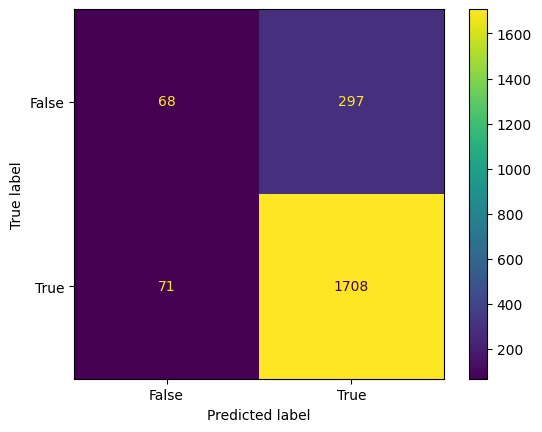

In [117]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


pred = lgb.predict(X_test_scaled)


cm = confusion_matrix(y_test, pred, labels=lgb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=lgb.classes_)
disp.plot()

plt.show()

# Iterasi 2

In [49]:
X_2 = df[['Administrative','ProductRelated','ExitRates','Informational']]
y_2 = df['not_revenue']
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, random_state=42)

print("X_train shape:", X_train_2.shape)
print("X_test shape:", X_test_2.shape)
print("y_train shape:", y_train_2.shape)
print("y_test shape:", y_test_2.shape)

X_train shape: (8575, 4)
X_test shape: (2144, 4)
y_train shape: (8575,)
y_test shape: (2144,)


In [50]:
scaler_2 = StandardScaler()
scaler_2.fit(X_train_2) 
X_train_scaled_2 = scaler_2.transform(X_train_2)  
X_test_scaled_2 = scaler_2.transform(X_test_2) 

In [51]:

smote = SMOTE(random_state=42)
X_res_2, y_res_2 = smote.fit_resample(X_train_scaled_2, y_train_2)

print('Original dataset shape:', Counter(y_train_2))
print('Resampled dataset shape:', Counter(y_res_2))

Original dataset shape: Counter({True: 7230, False: 1345})
Resampled dataset shape: Counter({True: 7230, False: 7230})


In [52]:
 result_df = pd.DataFrame(columns=[
       
    ])

In [53]:
def eval_classification(model):
    y_pred_train = model.predict(X_train_scaled_2)
    y_pred_test = model.predict(X_test_scaled_2)

    acc_train = accuracy_score(y_train_2, y_pred_train)
    acc_test = accuracy_score(y_test_2, y_pred_test)
    recall_train = recall_score(y_train_2, y_pred_train)
    recall_test = recall_score(y_test_2, y_pred_test)

    print("Accuracy (Train Set): %.2f" % acc_train)
    print("Accuracy (Test Set): %.2f" % acc_test)
    print("Recall (Train Set): %.2f" % recall_train)
    print("Recall (Test Set): %.2f" % recall_test)
    #
    score = cross_validate(model, X_train_scaled_2, y_train_2, cv=5, scoring='recall', return_train_score=True)
    print('recall (crossval test): '+ str(score['test_score'].mean()))

    data = pd.DataFrame({"Model" : [str(model)],
                         'Accuracy train' : [acc_train],
                         'Accuracy test' : [acc_test],
                         'Recall train' : [recall_train],
                         'Recall test' : [recall_test],
                         'recall_cv' : [score['test_score'].mean()]
                         })

    return data

In [54]:
def eval_classification_smote(model):
    y_pred_train = model.predict(X_res_2)
    y_pred_test = model.predict(X_test_scaled_2)

    acc_train = accuracy_score(y_res_2, y_pred_train)
    acc_test = accuracy_score(y_test_2, y_pred_test)
    recall_train = recall_score(y_res_2, y_pred_train)
    recall_test = recall_score(y_test_2, y_pred_test)

    print("Accuracy (Train Set): %.2f" % acc_train)
    print("Accuracy (Test Set): %.2f" % acc_test)
    print("Recall (Train Set): %.2f" % recall_train)
    print("Recall (Test Set): %.2f" % recall_test)
    #
    score = cross_validate(model, X_res_2, y_res_2, cv=5, scoring='recall', return_train_score=True)
    print('recall (crossval test): '+ str(score['test_score'].mean()))

    data = pd.DataFrame({"Model" : [str(model)],
                         'Accuracy train' : [acc_train],
                         'Accuracy test' : [acc_test],
                         'Recall train' : [recall_train],
                         'Recall test' : [recall_test],
                         'recall_cv' : [score['test_score'].mean()]
                         })

    return data

In [55]:
lgb2 = LGBMClassifier() # inisiasi object dengan nama rf
lgb2_smote = LGBMClassifier()

lgb2.fit(X_train_scaled_2, y_train_2) # fit model decision tree dari data train
lgb2_smote.fit(X_res_2,y_res_2)

result = eval_classification(lgb2)
result_smote = eval_classification_smote(lgb2_smote)
result_df = pd.concat([result_df, result], ignore_index=True)
result_df = pd.concat([result_df, result_smote], ignore_index=True)

[LightGBM] [Info] Number of positive: 7230, number of negative: 1345
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000611 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 528
[LightGBM] [Info] Number of data points in the train set: 8575, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.843149 -> initscore=1.681845
[LightGBM] [Info] Start training from score 1.681845
[LightGBM] [Info] Number of positive: 7230, number of negative: 7230
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000589 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1018
[LightGBM] [Info] Number of data points in the train set: 14460, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Accuracy (Train Set): 0.86
Accuracy (Test Set): 0.82
Recall (Train Set): 1.00

In [56]:
result_df

,Model,Accuracy train,Accuracy test,Recall train,Recall test,recall_cv
0,LGBMClassifier(),0.860991,0.819030,0.996819,0.981450,0.986584
1,LGBMClassifier(),0.856708,0.756996,0.879115,0.856099,0.835685


In [57]:
df_2 = pd.read_csv('dataset.csv')

df_2['not_revenue']  = np.where(df_2['Revenue'] == True,False,True)

In [58]:
df_2.Region = df_2.Region.astype('string').replace(['1', '2', '3', '4', '5', '6', '7', '8', '9'],
                      ['Jakarta', 'Bandung', 'Surabaya', 'Medan', 'Batam', 'Makassar', 'Tangerang', 'Yogyakarta', 'Semarang'])

df_2.Browser = df_2.Browser.astype('string').replace(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13'],
                                ['Safari', 'Google Chrome', 'Internet Explorer', 'Mozilla Firefox', 'Microsoft Edge', 'Samsung Internet', 'Maxthon Browser', 'Brave', 'Vivaldi', 'UC Browser', 'DuckDuckGo', 'Opera', 'Netscape Navigator'])

df_2.OperatingSystems = df_2.OperatingSystems.astype('string').replace(['1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0'],
                                                  ['iOS', 'Windows', 'Android', 'MAC OS', 'Blackberry', 'Chrome Os', 'Unix', 'Linux'])

df_2.TrafficType = df_2.TrafficType.astype('string').replace(['1', '2', '3', '4', '5', '6', '8', '10', '13'],
                                        ['Organic Search', 'Paid Search', 'Direct Traffic', 'Social Media', 'Facebook Ads', 'Referral Traffic', 'Email Marketing ', 'Display Advertising', 'Affiliate Marketing'])

In [59]:
df_2 = df_2.drop(df_2.loc[df_2['VisitorType'] =='Other'].index) 

df_2['OperatingSystems'] = df_2['OperatingSystems'].astype('string').replace(to_replace=os_replace,value='other')
df_2['Browser'] = df_2['Browser'].astype('string').replace(to_replace=browser_replace,value='other')
df_2['TrafficType'] = df_2['TrafficType'].astype('string').replace(to_replace=traffic_replace,value='other')

In [60]:
df_2.drop(columns=['Administrative_Duration'], inplace=True)
df_2.drop(columns=['Informational_Duration'], inplace=True)
df_2.drop(columns=['ProductRelated_Duration'], inplace=True)
df_2.drop(columns=['SpecialDay'], inplace =True)
df_2.drop(columns=['PageValues'], inplace=True)
df_2.drop(columns=['BounceRates'], inplace=True)

In [61]:
df_2 = pd.get_dummies(df_2, columns=columns_to_encode)

In [62]:
X_original = df_2.drop(columns=['not_revenue','Revenue'])
y_original = df_2['not_revenue']

X_original_2 = df_2[['Administrative','ProductRelated','ExitRates','Informational']]
y_original_2 = df_2['not_revenue']

In [63]:
scaler_1 = StandardScaler()
scaler_1.fit(X_original) 
X_scaled_1= scaler_1.transform(X_original)  

scaler_2 = StandardScaler()
scaler_2.fit(X_original_2) 
X_scaled_2 = scaler_2.transform(X_original_2)  

pred_1 = lgb.predict(X_scaled_1)
pred_2 = lgb2.predict(X_scaled_2)
pred_2_smote = lgb2_smote.predict(X_scaled_2)

NotFittedError: Estimator not fitted, call fit before exploiting the model.

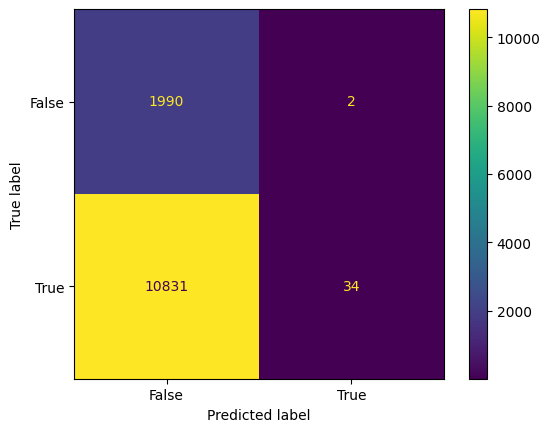

In [ ]:
cm = confusion_matrix(y_original, pred_1, labels=lgb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=lgb.classes_)
disp.plot()

plt.show()

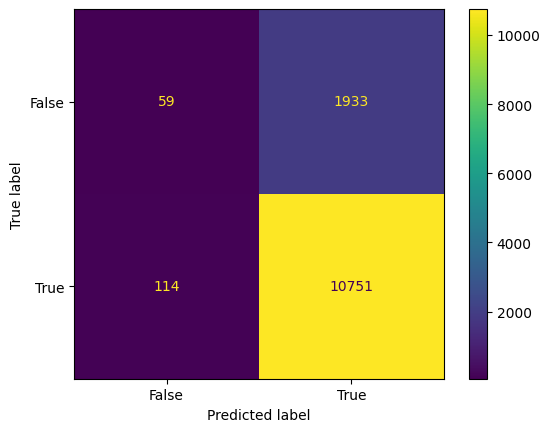

In [ ]:
cm = confusion_matrix(y_original_2, pred_2, labels=lgb2.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=lgb2.classes_)
disp.plot()

plt.show()

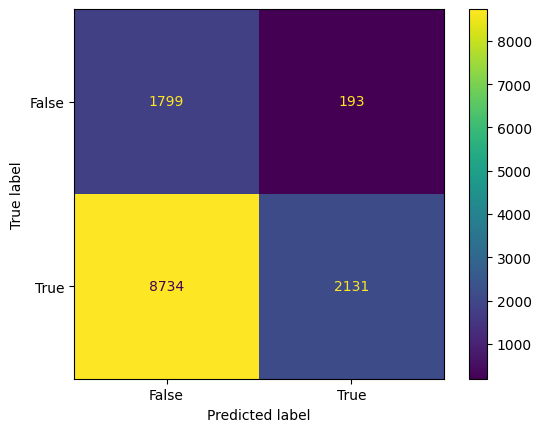

In [ ]:
cm = confusion_matrix(y_original_2, pred_2_smote, labels=lgb2_smote.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=lgb2_smote.classes_)
disp.plot()

plt.show()